### Charger les valeurs d'accuracy construites dans un précédent script (2018-02-16_clasiffier)

In [20]:
import numpy as np
import os

path = "MNIST_accuracy.npy"
if os.path.isfile(path):
    print('Loading accuracy...')
    accuracy =  np.load(path)
    print(accuracy)

Loading accuracy...
[[ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 ..., 
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]
 [ 0.0974  0.0974  0.0974 ...,  0.0974  0.0974  0.0974]]


### Afficher la carte d'accuracy

In [21]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from LogGabor import LogGabor

data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', 
                   train=False, 
                   download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
                   batch_size=1, 
                   shuffle=True)

def vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y):
    phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    params= {'sf_0':.1, 'B_sf': lg.pe.B_sf, 'theta':np.pi* 5 / 7., 'B_theta': lg.pe.B_theta}
    phase = np.pi/4
    edge = lg.normalize(lg.invert(lg.loggabor(N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))
    
    for i_theta in range(N_theta):
        for i_orient in range(N_orient):
            for i_scale in range(N_scale):
                ecc =  .5**(N_scale - i_scale)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
                y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
                for i_phase in range(N_phase):
                    params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                    phase = i_phase * np.pi/2
                    phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            
    return phi

N_theta, N_orient, N_scale, N_phase, N_X, N_Y = 6, 8, 5, 2, 128, 128
phi = vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y)
phi_vector = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
phi_plus = np.linalg.pinv(phi_vector)

def accuracy_128(i_offset, j_offset):
    N_pic = 128
    center = (128-55)//2
    
    accuracy_128 = accuracy[0][0] * np.ones((N_pic,N_pic))
    accuracy_128[(center+i_offset):(center+55+i_offset),(center+j_offset):(center+55+j_offset)] = accuracy
    
    accuracy_LP = phi_vector @ np.ravel(accuracy_128)
    
    image_hat = phi_plus @ accuracy_LP   
    fig, ax = plt.subplots(figsize=(13, 10.725))
    cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), image_hat.reshape((N_X, N_Y)))
    fig.colorbar(cmap)
    
    return accuracy_LP

def mnist_128(i_offset, j_offset):
    N_pic = 128
    center = (128-28)//2
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data_128 = data.min() * np.ones((128,128))
        data_128[(center+i_offset):(center+28+i_offset),(center+j_offset):(center+28+j_offset)] = data

        data_LP = phi_vector @ np.ravel(data_128)
        
        image_hat = phi_plus @ data_LP
        fig, ax = plt.subplots(figsize=(13, 10.725))
        cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), image_hat.reshape((N_X, N_Y)))
        fig.colorbar(cmap)
        if batch_idx == 0: break
     
    return data_LP

def couples(i_offset, j_offset):
    v = mnist_128(i_offset, j_offset)
    a = accuracy_128(i_offset, j_offset)
    
    return (v,a)

(array([ -6.77936819e-03,  -4.99567808e-03,   3.98095803e-02,
          3.30918401e-02,   3.52110715e+00,  -4.33210255e+00,
         -8.69821404e+00,   3.24069784e+00,   1.23717469e+01,
          8.75407017e+00,  -1.97084072e-04,  -9.37528630e-04,
         -1.72199172e-02,  -7.85410313e-03,   9.27643466e-01,
          3.82532494e-01,   3.57135733e+00,  -6.90205812e-02,
         -1.14166356e+01,   2.15700815e+00,   1.58918324e-04,
          5.67369049e-04,   1.02922517e-02,  -1.20185444e-03,
         -2.99136748e-01,  -1.20044764e-01,  -9.63378944e-01,
         -1.53551102e+00,   5.59450498e+00,   1.13338138e+01,
          6.34718586e-04,  -1.69779839e-04,  -5.17748615e-03,
          1.24683571e-02,   1.72921831e-01,   7.11084620e-02,
          8.55128452e-01,   8.41022305e-01,   1.58795531e+00,
         -5.30233144e+00,  -1.00041248e-03,  -1.76480972e-03,
         -3.55848742e-02,   2.14989076e-02,  -1.25916787e-01,
          2.38266944e-01,   1.21751533e+00,   2.47122836e+00,
        

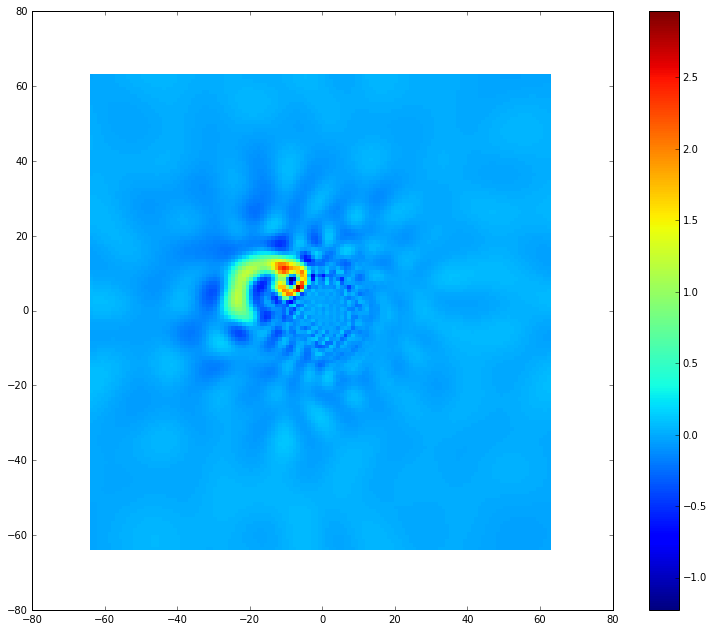

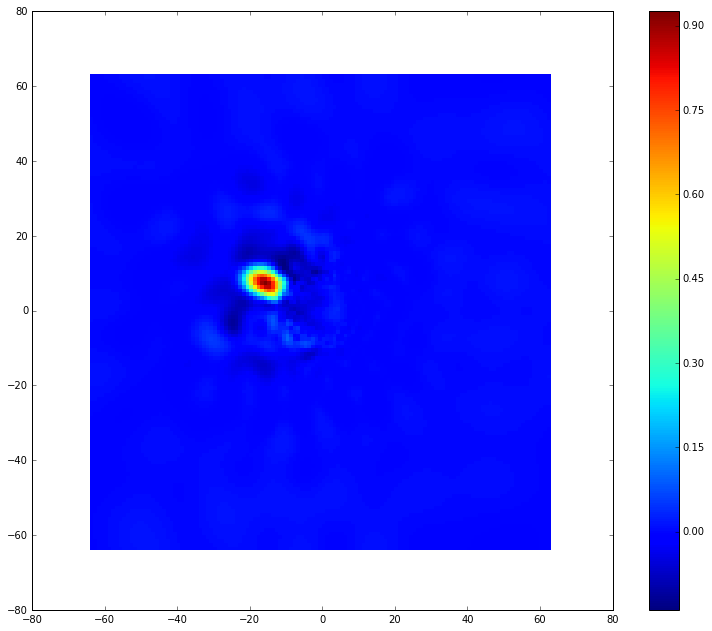

In [22]:
i_offset, j_offset = np.random.randn()*10, np.random.randn()*10 
couples(i_offset, j_offset)